In [54]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from datetime import datetime
from dataclasses import dataclass, field
import glob
import os
import eigsep_observing as eo
import jax
import jax.numpy as jnp
import optax
from functools import partial
%matplotlib widget

## I measured the dimensions of my antenna

* l = 235 mm, one rod, middle piece is about 37 mm, so whole thing is about 507 mm, about .507 m
* d = 6 mm, so a = 3 mm = .003 m
* r = 97 m, from notes

In [2]:
waveform = np.load('/home/dominiv/eigsep/data/july2025/trans_spec/transmitter.npz')
print(waveform.keys())
bram = waveform['max_addr']
waveform = waveform['data']
trans_spec = np.fft.fft(waveform)

Vfwd_bit = np.max(waveform)
bit_range = 2**(13) # data is signed, so its 2^13 not 14
V_rfsoc = 2 # RFSoC's DAC range, +- volts peak-peak
output = (V_rfsoc) / (bit_range-1)
Vpeak = Vfwd_bit * output
Vfwd = Vpeak/np.sqrt(2) # Vrms conversion
print(Vfwd)

KeysView(NpzFile '/home/dominiv/eigsep/data/july2025/trans_spec/transmitter.npz' with keys: data, max_addr)
1.2728094715925353


In [3]:
path = '/home/dominiv/eigsep/data/july2025/corr_data/'
def file_finder(path, date, start, end):
    files = glob.glob(path+'corr_'+date+'_*')
    start_time = datetime.strptime(date+f'_{start}', '%Y%m%d_%H%M%S')
    end_time = datetime.strptime(date+f'_{end}', '%Y%m%d_%H%M%S')
    filtered_files = []
    for file in files:
        basename = os.path.basename(file)
        try:
            timestamp_str = basename[5:-3]  # Strip 'corr_' prefix and '.h5' suffix
            file_time = datetime.strptime(timestamp_str, "%Y%m%d_%H%M%S")
            if start_time <= file_time <= end_time:
                filtered_files.append(file)
        except ValueError:
            continue
    ordered_files = sorted(filtered_files)
    print('Number of files:', len(ordered_files))
    print(f'{str(ordered_files[0])}, {str(ordered_files[-1])}')
    return ordered_files

def header_check(picos, idx, header='imu_panda'):
    if f'{header}' not in picos.keys():
        print(f'{header} not found in file:', idx)

def data_extract(files):
    data_list = []
    corr_list = []
    pico_list = []
    for i in range(len(files)):
        data, corr, pico = eo.io.read_hdf5(files[i])
        header_check(pico, i)
        data_list.append(data)
        corr_list.append(corr)
        pico_list.append(pico)
    return data_list, corr_list, pico_list

def spectra(data, ant, corr):
    data_stack = [d[ant] for d in data]
    data_stack = np.array(data_stack)
    data_stack = np.concatenate(data_stack, axis=0)

    times = [d['times'] for d in corr]
    times = np.array(times)
    times = np.concatenate(times, axis=0)
    return data_stack, times

def waterfall(data, times, freqs, pos=False):
    dt = [datetime.fromtimestamp(ts) for ts in times]
    t_md = mdates.date2num(dt)
    plt.figure(figsize=(10,6))
    plt.imshow(np.log10(data), aspect = 'auto', interpolation='none', extent = [freqs[0], freqs[-1], t_md[-1], t_md[0]], 
               origin='upper', cmap='viridis')
    ax = plt.gca()
    ax.yaxis_date()
    ax.yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Time of Day')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

def plotter(freqs, spec, amount=[0,0]):
    plt.figure(figsize=(10,6))
    if spec.shape[:][0] > 1 and amount != [0,0]:
        for i in range(amount[0], amount[1]):
            plt.semilogy(freqs, spec[i], label=f'Spectra index: {i}')
    else:
        plt.semilogy(freqs, spec, label='Spectra')
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.show()



def pico_info(picos, device, info):
    pico = [d[device] for d in picos]
    print(len(pico))
    print(type(pico))
    print(type(pico[0]))
    pl   = [entry[info] 
            for sublist in pico 
            for entry   in sublist]
    print(type(pl), len(pl))
    return np.array(pl)


sunday = file_finder(path, '20250720', '092000', '111200') # sunday from 9:58 pdt, battery swap at around 11:01 (12:01 in notes) (original was 9:58 to 12:13, is wrong)


data, corr, pico = data_extract(sunday)

data_stack, times = spectra(data, '2', corr) # use after friday for box data

Number of files: 24
/home/dominiv/eigsep/data/july2025/corr_data/corr_20250720_092946.h5, /home/dominiv/eigsep/data/july2025/corr_data/corr_20250720_110841.h5


In [4]:
@dataclass
class MotorSteps:
    az_range_deg : np.ndarray
    el_range_deg : np.ndarray
    el_first : bool
    start : dict[str, int] = field(default_factory=lambda: {"az": 0, "el": 0})  # start pos in steps
    up_delay_us : dict[str, int] = field(default_factory=lambda: {"az": 2400, "el": 2400})
    dn_delay_us : dict[str, int] = field(default_factory=lambda: {"az": 300, "el": 600})
    slowdown_factor : int = 2
    slow_zone : int = 100  # in steps
    step_angle_deg : float = 1.8
    microstep : int = 1
    gear_teeth : int = 113

    def __post_init__(self):
        self.extra_delay = {k: self.slowdown_factor * v for k, v in self.dn_delay_us.items()}

        if self.el_first:
            self.axis1 = "az"  # the slow axis
            self.axis2 = "el"  # fast axis / inner loop
            self.ax1_rng = az_range_deg.copy()
            self.ax2_rng = el_range_deg.copy()
        else:
            self.axis1 = "el"
            self.axis2 = "az"
            self.ax1_rng = el_range_deg.copy()
            self.ax2_rng = az_range_deg.copy()

    def steps2deg(self, steps):
        s = steps / self.microstep / self.gear_teeth
        deg = s * self.step_angle_deg
        return float(deg)
    
    def deg_to_steps(self, degrees):
        s = degrees / self.step_angle_deg
        return int(s * self.microstep * self.gear_teeth)

    @property
    def steps(self):
        """
        Calculate the list of steps taken.

        Returns
        -------
        s : list
            Each element is a tuple of (axis, number of steps).

        """
        # steps per position
        # inner: full range every time
        nsteps_inner = self.deg_to_steps(self.ax2_rng[-1] - self.ax2_rng[0])
        # outer: one position each time  (assumes here that each position has the same step increment -- an always valid assumption in our case)
        nsteps_outer = self.deg_to_steps(self.ax1_rng[1] - self.ax1_rng[0])
        # for each outer position, take nsteps_inner steps on inner axis and then nsteps_outer steps on outer axis to get to next outer pos
        s = [(self.axis1, nsteps_outer), (self.axis2, nsteps_inner)] * self.ax1_rng.size
        # first outer step is taken into account in separate stow calculation so remove it from here
        return s[1:]

    @property
    def positions(self):
        """
        Get the arrays of postions.

        Returns
        -------
        dict
            Key is axis name, value is array of positions.
        """
        a2, a1 = np.meshgrid(self.ax2_rng, self.ax1_rng)
        a1 = a1.ravel()
        a2[1::2] = a2[1::2, ::-1]  # reverse every a1 position
        a2 = a2.ravel()
        return {self.axis1: a1, self.axis2: a2}

    def stow_time(self):
        raise NotImplementedError

    def calc_time(self, include_stow=False):
        t = 0
        for ax, ns in self.steps:
            nslow = np.minimum(2*self.slow_zone, ns)  # number of slow steps
            t += ns * (self.dn_delay_us[ax] + self.up_delay_us[ax]) + nslow * self.extra_delay[ax]
        if include_stow:
            t += self.stow_time()
        return t / 1e6

In [5]:
az_range_deg = np.linspace(-180.0, 180.0, 72, endpoint=False)
el_range_deg = np.linspace(-180.0, 180.0, 72, endpoint=False)
ms = MotorSteps(az_range_deg, el_range_deg, el_first=True)

pos        = ms.positions
az_seq     = pos['az']       # (5184,)
el_seq     = pos['el']

# rename your "times" to "scan_times"
scan_times = np.zeros(len(az_seq), float)

def step_time(ax, n_steps):
    base  = ms.up_delay_us[ax] + ms.dn_delay_us[ax]
    slow  = min(2*ms.slow_zone, n_steps)
    extra = slow * ms.extra_delay[ax]
    return (n_steps*base + extra) / 1e6

# 2) loop over scan points (not over measurements!)
for i in range(len(az_seq)-1):
    da = abs(az_seq[i+1] - az_seq[i])
    de = abs(el_seq[i+1] - el_seq[i])
    sa = ms.deg_to_steps(da) if da>0 else 0
    se = ms.deg_to_steps(de) if de>0 else 0
    scan_times[i+1] = scan_times[i] + step_time('az', sa) + step_time('el', se)

# 3) prepare your measurement‐clock
t_unix      = np.array(times, dtype=float)   # (5760,)
t0          = t_unix[0]                     # or your known scan start
t_elapsed   = t_unix - t0                    # (5760,)  

# 4) interpolate az/el at each measurement time
az_aligned  = np.interp(t_elapsed, scan_times, az_seq,
                        left=az_seq[0], right=az_seq[-1])
el_aligned  = np.interp(t_elapsed, scan_times, el_seq,
                        left=el_seq[0], right=el_seq[-1])

# 5) bundle (all length 5760)
data1       = np.array(data_stack)                # (5760,1024)
aligned = {
    't_unix':   t_unix,       # original Unix times
    't_elapsed':t_elapsed,    # seconds since t0
    'az':       az_aligned,   # (5760,)
    'el':       el_aligned,   # (5760,)
    'data1':    data1,        # (5760,1024)
}

(5690,) (5690,)


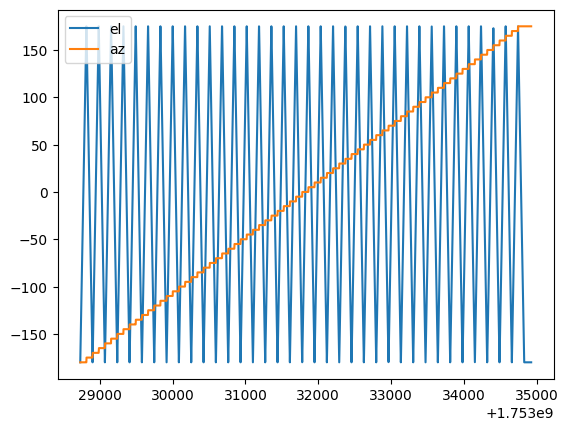

In [6]:

cutoff_point = 5690


big_az = aligned['az'][:cutoff_point]
big_el = aligned['el'][:cutoff_point]
print(big_az.shape, big_el.shape)

plt.figure()
# plt.plot(aligned['t_unix'])
plt.plot(aligned['t_unix'], aligned['el'], label = 'el')
plt.plot(aligned['t_unix'], aligned['az'], label = 'az')
plt.legend()
plt.show()

In [7]:
class Beam_finder:
    def __init__(self, a=.002, r=1, l=.33):
        self.a = a
        self.r = r
        self.l = l
        self.c = 3e8
        self.Vfwd = 1.2728094715925353

    def T11(self, theta, phi):
        return ((jnp.cos(theta)) * (jnp.cos(phi)))**2
    
    def T12(self, theta, phi):
        return -jnp.cos(theta) * jnp.cos(phi) * jnp.sin(phi)
    
    def T22(self, phi):
        return jnp.sin(phi)**2
    
    def T_mat(self, theta, phi):
        t11 = self.T11(theta, phi)
        t12 = self.T12(theta, phi)
        t21 = self.T12(theta, phi)
        t22 = self.T22(phi)
        mat = jnp.array([[t11, t12], [t21, t22]])
        return mat
    
    def Zin(self, freq):
        Rrad = 20 * jnp.pi**2 * ((freq * self.l) / self.c)**2
        X = (-120 / jnp.pi) * (self.l * freq / self.c) * (jnp.log(self.l / (2 * self.a)) -1)
        return Rrad + 1j*X
    
    def Prad(self, freq):
        z0 = 50 # ohms, most cables have 50 ohm impedence
        z = self.Zin(freq)
        tau = (z - z0) / (z + z0)
        eff = 1 - jnp.abs(tau)**2
        eta = .9 # antenna made of aluminum, so Rloss is approx 0, so eta is approx 1
        # return Pav * eff * eta # Pav is our T matrix? dont really need?
        Pfwd = (jnp.abs(self.Vfwd)**2) / z0
        Pin = eff * Pfwd
        return Pin * eta
    
    def vis_(self, freq, theta, phi, A):
        P = self.Prad(freq)
        t_mat = self.T_mat(theta, phi) * P
        A_conj = jnp.conj(A).T
        con_mult = jnp.dot(t_mat, A_conj)
        v = jnp.dot(A, con_mult)
        return jnp.array(v)[0][0]

    def loss(self, A, freq, theta, phi, V):
        model = self.vis_(freq, theta, phi, A)
        res = jnp.mean((model - V)**2)
        return res
    
    @partial(jax.jit, static_argnums=(0,))
    def update(self, A, opt_state, freq, theta, phi, V):
        g = jax.grad(self.loss)(A, freq, theta, phi, V)
        updates, opt_state = opt.update(g, opt_state)
        return optax.apply_updates(A, updates), opt_state
   
    def A_mag(self, A):
        return np.linalg.norm(A)
    
    def T_mag(self, freq, T):
        P = self.Prad(freq)
        return np.linalg.norm(T * P)

    def save_beam(self, freq, A, idx, perc):
        np.savez(self.path + f'beam_at_{freq:.0f}MHz', As = A, err_idx = idx, err_perc = perc)
   
    def find_beam(self, freq, theta, phi, A_init, V, learning_rate=10, iteration=10000):
        loss_grad = jax.jit(jax.grad(self.loss))
        opt = optax.adam(learning_rate)
        opt_state = opt.init(A_init)
        A = A_init
        
        for i,frequency in enumerate(freq):
            As = []
            err_idx = []
            err_perc = []
            for j in range(len(theta)):
                for _ in range(iteration):
                    A, opt_state = self.update(A, opt_state, frequency, theta[j], phi[j], V[i][j])
                mag = self.A_mag(A)
                A_vis = self.vis_(frequency, theta[j], phi[j], A)
                percent_diff = (A_vis - V[i][j]) / V[i][j] * 100
                if jnp.abs(percent_diff) >= 5:
                    err_idx.append(j)
                    err_perc.append(percent_diff)
            As = np.array(As)
            err_idx = np.array(err_idx)
            err_perc = np.array(err_perc)
            self.save_beam(frequency, As, err_idx, err_perc)
            print(f'Saved beam at {frequency} MHz')

In [58]:
class Beam_finder:
    def __init__(self, a: float = 0.002, r: float = 1.0, l: float = 0.33, path='./'):
        self.a = a
        self.r = r
        self.l = l
        self.c = 3e8
        self.Vfwd = 1.2728094715925353
        self.path = path
        os.makedirs(self.path, exist_ok=True)

    def T11(self, theta, phi):
        return (jnp.cos(theta) * jnp.cos(phi))**2

    def T12(self, theta, phi):
        return -jnp.cos(theta) * jnp.cos(phi) * jnp.sin(phi)

    def T22(self, phi):
        return jnp.sin(phi)**2

    def T_mat(self, theta, phi):
        t11 = self.T11(theta, phi)
        t12 = self.T12(theta, phi)
        t21 = t12
        t22 = self.T22(phi)
        return jnp.array([[t11, t12],
                          [t21, t22]])

    def Zin(self, freq):
        Rrad = 20 * jnp.pi**2 * ((freq * self.l) / self.c)**2
        X = (-120 / jnp.pi) * (self.l * freq / self.c) * (jnp.log(self.l / (2 * self.a)) - 1)
        return Rrad + 1j * X

    def Prad(self, freq):
        z0 = 50.0
        z = self.Zin(freq)
        tau = (z - z0) / (z + z0)
        eff = 1 - jnp.abs(tau)**2
        eta = 0.9
        Pfwd = (jnp.abs(self.Vfwd)**2) / z0
        return eff * Pfwd * eta

    def vis_(self, freq, theta, phi, A):
        P = self.Prad(freq)
        t_mat = self.T_mat(theta, phi) * P
        A_conj = jnp.conj(A).T
        result = (A @ (t_mat @ A_conj))[0, 0]
        return result

    def loss(self, A, freq, theta, phi, V):
        pred = self.vis_(freq, theta, phi, A)
        return jnp.mean((pred - V)**2)

    @partial(jax.jit, static_argnames=('self','optimizer'))
    def update(self, A, opt_state, freq, theta, phi, V, optimizer):
        grads = jax.grad(self.loss)(A, freq, theta, phi, V)
        updates, new_opt_state = optimizer.update(grads, opt_state)
        new_A = optax.apply_updates(A, updates)
        return new_A, new_opt_state

    def save_beam(self, freq, A_host, err_idx, err_perc):
        """A_host, err_idx, err_perc should be plain NumPy arrays."""
        fn = os.path.join(self.path, f'beam_{freq:.0f}MHz.npz')
        np.savez(fn, A=A_host, err_idx=err_idx, err_perc=err_perc)
        print(f"saved: {fn}")

    def find_beam(self,
                  freqs, 
                  thetas,
                  phis,  
                  A_init,
                  V,     
                  learning_rate=10.0,
                  iterations=10000):

        optimizer = optax.adam(learning_rate)

        for i, freq in enumerate(freqs):
            A = A_init
            opt_state = optimizer.init(A)

            As = []
            err_idx = []
            err_perc = []
            for j, (θ, ϕ) in enumerate(zip(thetas, phis)):
                print(j)
                V_meas = V[j, i]
                for _ in range(iterations):
                    A, opt_state = self.update(
                        A, opt_state,
                        freq, θ, ϕ, V_meas,
                        optimizer
                    )
                As.append(A)
                A_vis = self.vis_(freq, θ, ϕ, A)
                pdiff = (A_vis - V_meas) / V_meas * 100
                if jnp.abs(pdiff) >= 5:
                    err_idx.append(j)
                    err_perc.append(pdiff)

            As_host      = jax.device_get(jnp.stack(As))
            err_idx_host = np.array(jax.device_get(jnp.array(err_idx)))
            err_perc_host= np.array(jax.device_get(jnp.array(err_perc)))

            self.save_beam(freq, As_host, err_idx_host, err_perc_host)

        return As_host

In [37]:
data_stack[:,::16][:,0].shape
# last_vis = data_stack[:,::16][:,-1]
all_my_freqs = jnp.array(corr[0]['freqs'][::16]) * 1e6
all_my_vis = jnp.array(data_stack[:, ::16][:cutoff_point])
last_vis = data_stack[:,::16][:cutoff_point][:, :2]
first_freq = jnp.array(corr[0]['freqs'][::16][:2]) * 1e6
A_num = jnp.array([[6.6e4], [6.6e4]], dtype=float).T
print(first_freq)
print((big_el.shape), (big_az.shape), (last_vis.shape), first_freq.shape)
print(all_my_freqs[17:19], all_my_vis[:,13:].shape)

[      0. 3906250.]
(5690,) (5690,) (5690, 2) (2,)
[66406248. 70312496.] (5690, 51)


In [9]:
b = Beam_finder(a=.003, r=97, l=.507)
b.find_beam(all_my_freqs[40:41], big_el, big_az, A_num, all_my_vis[:,40:41])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

array([[[ 60450.27 ,  71548.65 ]],

       [[ 18575.533,  29673.87 ]],

       [[ 20460.762,  34442.766]],

       ...,

       [[-16036.68 ,  26722.63 ]],

       [[-14485.954,  25171.912]],

       [[-12685.216,  23371.168]]], dtype=float32)

In [41]:
def beam_map(A, theta, phi, freq, nside=16, fwhm=45, iterations=100, logscale=True):
    if type(A[0]) != np.float64:
        A = np.squeeze(A, axis=1)
        A_mags = np.linalg.norm(A, axis=1)
    else:
        A_mags = A
        
    npix = hp.nside2npix(nside)
    
    m = np.full(npix, hp.UNSEEN)
    theta = np.mod(theta, 2*np.pi)
    new_theta = np.where(theta > np.pi, 2*np.pi - theta, theta)
    
    new_phi = np.mod(phi, 2*np.pi)
    pix = hp.ang2pix(nside, new_theta, new_phi)
    if logscale:     
        for p, v in zip(pix, A_mags):
            m[p] = np.log10(v)
    else:
        for p, v in zip(pix, A_mags):
            m[p] = v
    
    m_smooth= hp.smoothing(m, fwhm=np.radians(fwhm), iter=iterations)
    
    neighbours = hp.get_all_neighbours(nside, np.arange(npix))
    mask = m_smooth == hp.UNSEEN
    for pix in np.where(mask)[0]:
        nbrs = neighbours[:, pix]
        valid = nbrs[nbrs>=0]
        vals = m_smooth[valid]
        vals = vals[vals!=hp.UNSEEN]
        if vals.size:
            m_smooth[pix] = vals.mean()
    hp.mollview(m_smooth, title=f'Beam at {freq/1e6:.3f} MHz')
    plt.show()
    return m_smooth

rad_theta = np.deg2rad(big_el)
rad_phi = np.deg2rad(big_az)


In [49]:
all_my_freqs[-2]

Array(2.421875e+08, dtype=float32)

(126,) (99,)


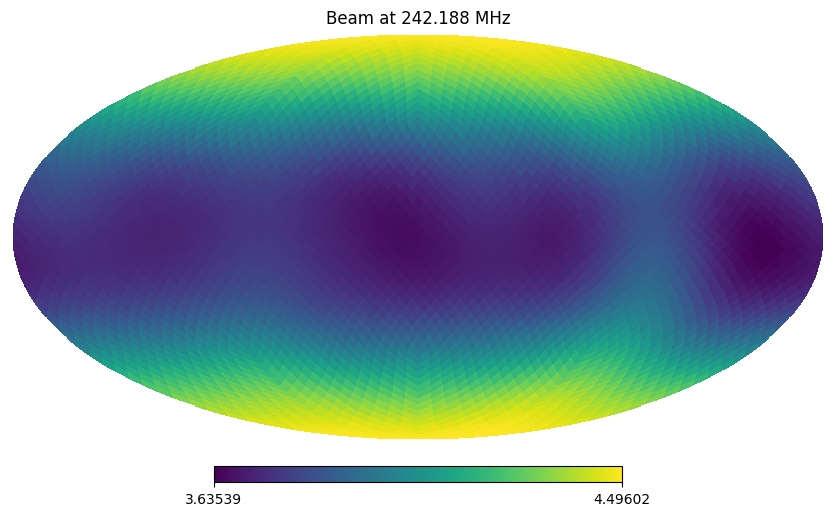

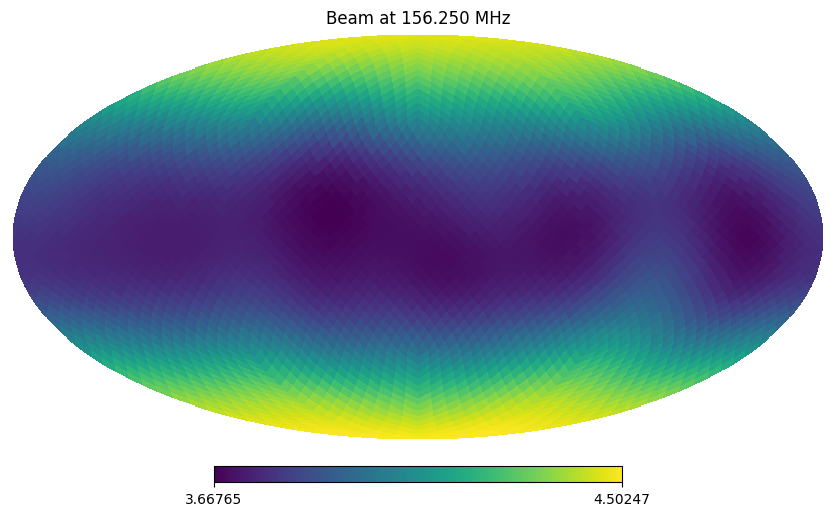

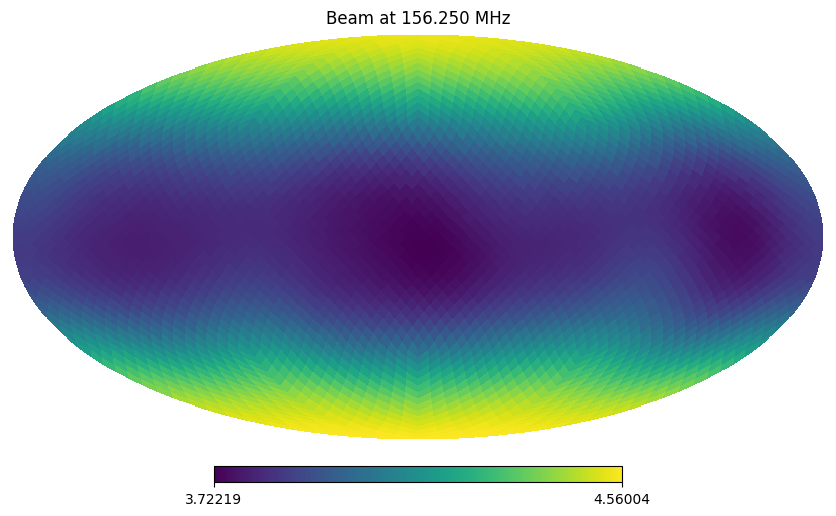

In [51]:
s156 = np.load('/home/dominiv/eigsep/my_notebooks/july2025/beam_156250000MHz.npz')
s156_old = np.load('/home/dominiv/eigsep/my_notebooks/july2025/sunday_156MHz_A_map_update.npz')
s70 = np.load('/home/dominiv/eigsep/my_notebooks/july2025/beam_242187500MHz.npz')

s70_A = s70['A']
s156_A = s156['A']
s156_old_A = s156_old['As']

s156_perc = s156['err_perc']
s156_old_perc = s156_old['err_perc']

print(s156_old_perc.shape, s156_perc.shape)
smooth_map70 = beam_map(s70_A, rad_theta, rad_phi, all_my_freqs[-2])
smooth_map156 = beam_map(s156_A, rad_theta, rad_phi, all_my_freqs[40])
smooth_map156 = beam_map(s156_old_A, rad_theta, rad_phi, all_my_freqs[40])

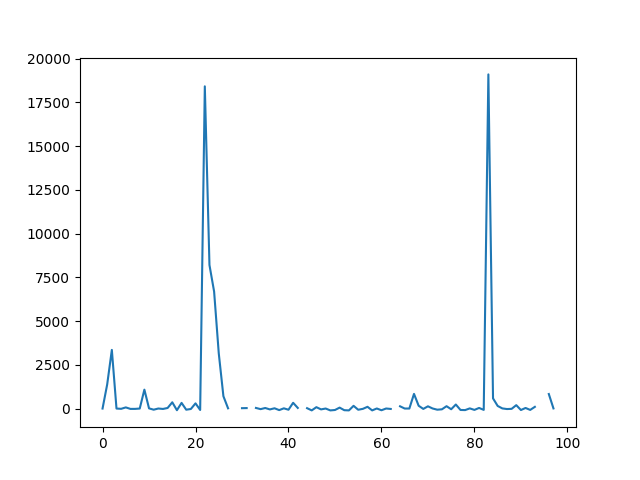

In [57]:
plt.figure()
plt.plot(s156_perc)
# plt.plot(s156_old_perc)
plt.show()

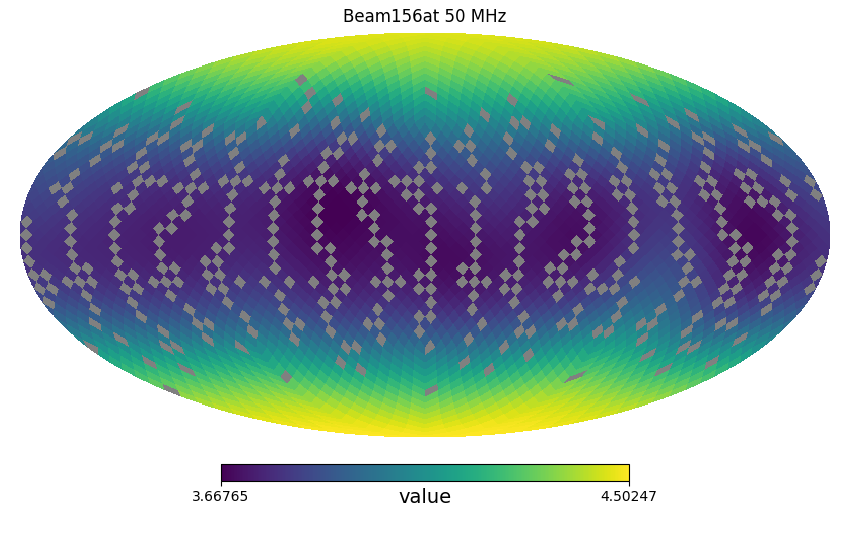

In [59]:
s156_A = np.squeeze(s156_A, axis=1)

A_mags = np.linalg.norm(s156_A, axis=1)
nside = 16 # used 16
npix  = hp.nside2npix(nside)

m156= np.full(npix, hp.UNSEEN)
theta_mod = np.mod(np.deg2rad(big_el), 2*np.pi)
new_theta = np.where(theta_mod > np.pi,
                 2*np.pi - theta_mod,
                 theta_mod)

new_phi = np.mod(np.deg2rad(big_az), 2*np.pi)
pix = hp.ang2pix(nside, new_theta, new_phi)

for p, v in zip(pix, A_mags):
    m156[p] = np.log10(v)
    # m[p] = (v)

m_smooth156 = hp.smoothing(
    m156,
    fwhm=np.radians(45),  
    iter=100,                
) # used fwhm=np.radians(45) and iter=100


# — plot it —
hp.mollview(
    m_smooth156,
    title=f"Beam156at {50} MHz",
    unit="value",
    # rot=(0,90,0)
    # min=0,
    # max=A_mags.max()
)
# hp.graticule()
plt.show()

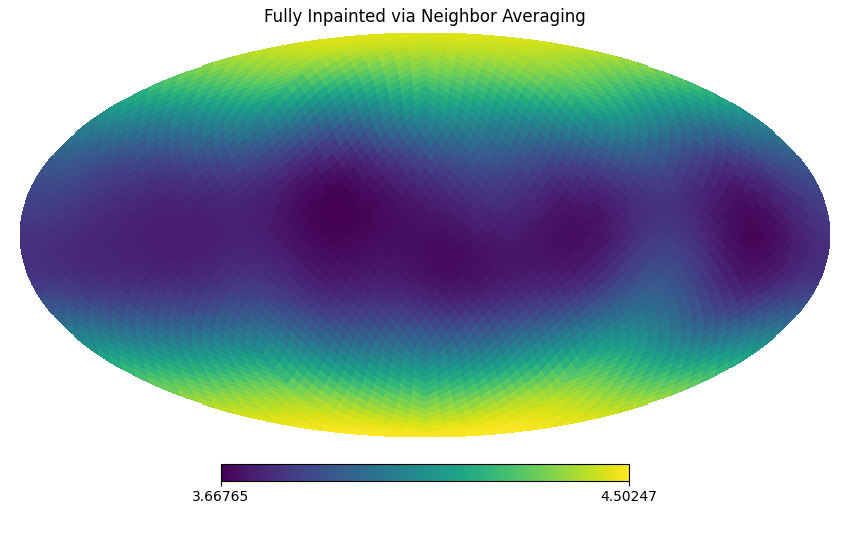

In [60]:

neighbors = hp.get_all_neighbours(nside, np.arange(npix))  # shape (8, npix)
m_nn156 = m_smooth156.copy()

for _ in range(1):  # do up to 10 sweeps
    mask = m_nn156 == hp.UNSEEN
    if not np.any(mask):
        break
    for pix in np.where(mask)[0]:
        nbrs = neighbors[:, pix]
        # discard out-of-range neighbours (==-1) and UNSEEN
        valid = nbrs[nbrs>=0]
        vals  = m_nn156[valid]
        vals  = vals[vals!=hp.UNSEEN]
        if vals.size:
            m_nn156[pix] = vals.mean()

hp.mollview(m_nn156, title="Fully Inpainted via Neighbor Averaging")
# hp.graticule()
plt.show()